In [9]:
%load_ext autoreload
%autoreload 2
from Network import Network
from FrankWolf import *
from EntropyMaximisation import *
from RemoveBraess import *

import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import seaborn.objects as so

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Identification of Braess links in traffic networks - Initial network calculations

This project aims to verify the hypothesis that Braess links could be identified with an adequate comparison of link flows at UE and at SO for a given OD.

In particular, we would like to verify whether links that, for a given OD, are used at UE (i.e. flow is significant) but not at SO (i.e. SO flow is not significant) are Braess links.

To start with, we need to compute the UE and SO flows for each OD pair. We will use the SiouxFalls network to test our hypothesis.

## Network creation

First, we create a `Network` instance that represent SiouxFalls network, using data from [the TransportationNetworks Github repo](https://github.com/bstabler/TransportationNetworks)

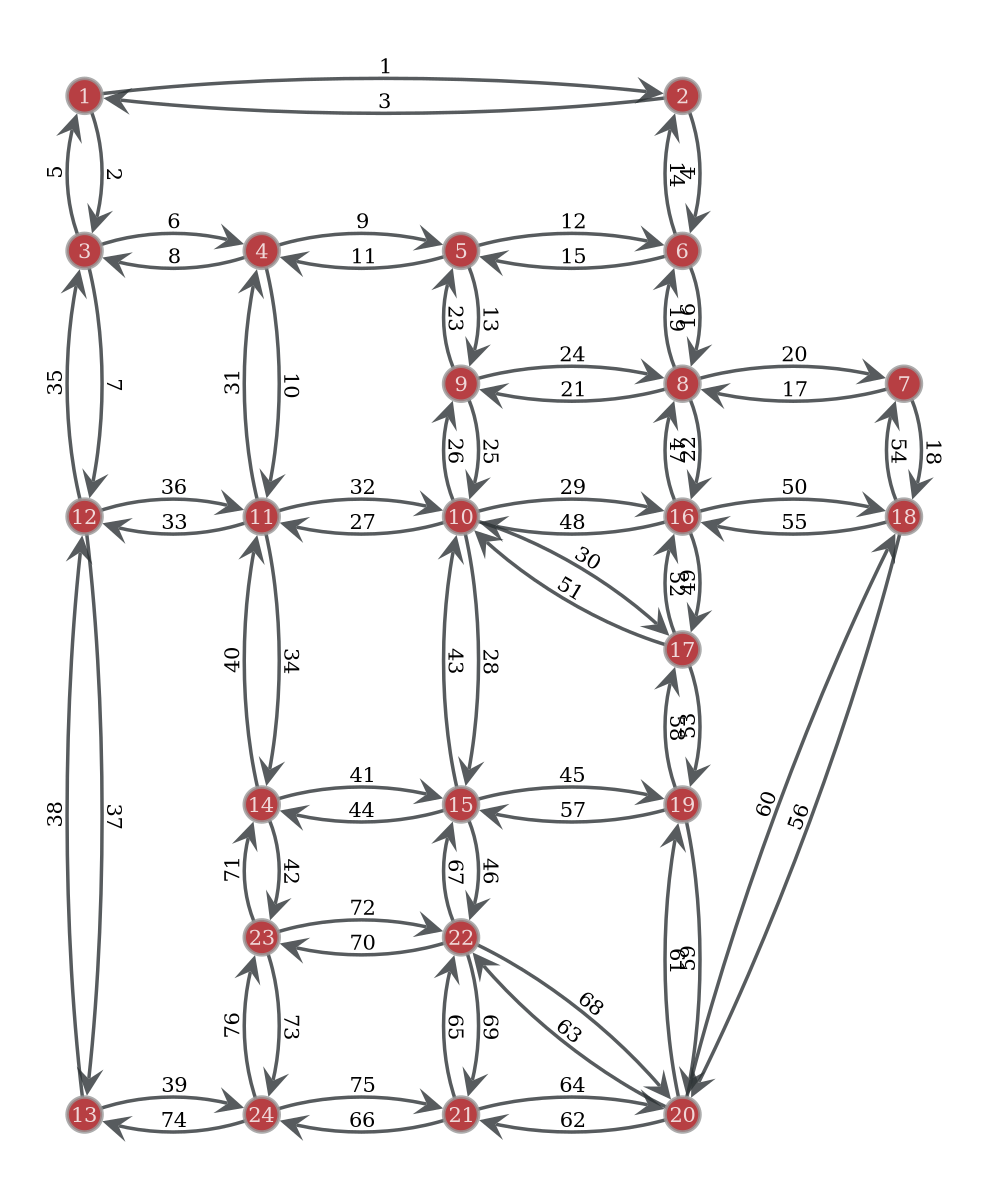

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2d0e1c58b0, at 0x7f2d10215400>

In [10]:
net = Network("SiouxFalls")
net.draw(output="figs/SiouxFalls.pdf")
net.draw()

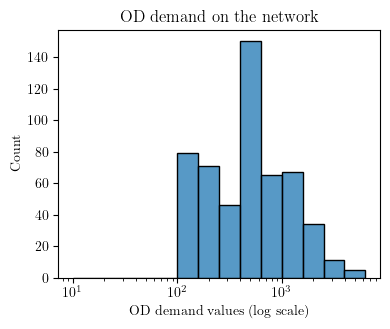

In [11]:
sns.histplot(net.trips.flatten(), log_scale=True, bins=np.arange(1, 4, 0.2))
plt.gcf().set_size_inches(4, 3)
plt.tight_layout()
plt.title("OD demand on the network")
plt.xlabel("OD demand values (log scale)")
plt.savefig("figs/OD_demand_histogram.pgf",bbox_inches = 'tight')
plt.show()

## Computations

Now, we will compute UE and SO flows this way :
1. Computing UE link flows using a frankwolf algorithm (These flows are unique)
2. Using Entropy Maximization through Alternative Representation of Bushes (EMARB) algorithm from Xie and Nie : A New Algorithm for Proportionality, we will equilibrate the path flows for every OD. This will give origin-based bushes
3. Get OD flows by reproducing the paths from the previous results

### A note on precision

Using our own Frank Wolf algorithm, and our own shortest path algorithm implementation, in python, we might not have the most optimised computation. As such, we might need to make a trade off between precision and performance.

Here, we will first run the FrankWolf algorithm with different precisions, and note the time it takes. We will then compare our results with the flows publicly availlable from the Transportation Networks github, and estimate our error from these flows.

In [12]:
import time

In [13]:
# Run the frankwolf algorith for different precisions and save the results
for i in range(2, 7, 1):
    print(f"Tolerance : 1e-{i}")
    start = time.time()
    frankwolf_by_origin, frankwolf_flows = frankwolf(net, net.trips, verbose=1, tolerance= 10**(-i), n_max=2e5)
    end = time.time()
    diff = end - start
    minutes = diff / 60
    print(f"Took {minutes:.2f} minutes")
    net.save_flow(frankwolf_by_origin, f"fw_p{i}", folder = os.path.join("files", "precision"))
    net.save_flow(frankwolf_flows, f"fw_p{i}", folder = os.path.join("files", "precision"))
    net.export_flow(frankwolf_by_origin, f"fw_p{i}", folder = os.path.join("exports", "precision"))
    net.export_flow(frankwolf_flows, f"fw_p{i}", folder = os.path.join("exports", "precision"))

# Save the results with the highest precision, for future use
net.save_flow(frankwolf_by_origin, "UE_FrankWolf_by_origin")
net.save_flow(frankwolf_flows, "UE_flows")
net.export_flow(frankwolf_by_origin, "UE_FrankWolf_by_origin")
net.export_flow(frankwolf_flows, "UE_flows")

Tolerance : 1e-2


26it [00:01, 20.22it/s, Relative error=9.68e-03]


Took 0.02 minutes
Tolerance : 1e-3


124it [00:05, 23.32it/s, Relative error=9.45e-04]


Took 0.09 minutes
Tolerance : 1e-4


1104it [00:52, 20.85it/s, Relative error=9.95e-05]


Took 0.88 minutes
Tolerance : 1e-5


9973it [08:04, 20.57it/s, Relative error=9.53e-06]


Took 8.08 minutes
Tolerance : 1e-6


95436it [1:23:27, 19.06it/s, Relative error=9.96e-07]


Took 83.46 minutes


,Root mean square (absolute error),Root mean square (relative error),Mean relative error,Computation time [min]
Precision,,,,
10^-2,373.261068,0.035250,-0.013116,0.04
10^-3,57.426716,0.005110,-0.001624,0.16
10^-4,6.115646,0.000534,-0.000176,1.42
10^-5,0.729780,0.000063,-0.000019,12.99
10^-6,0.072859,0.000006,-0.000002,133.60


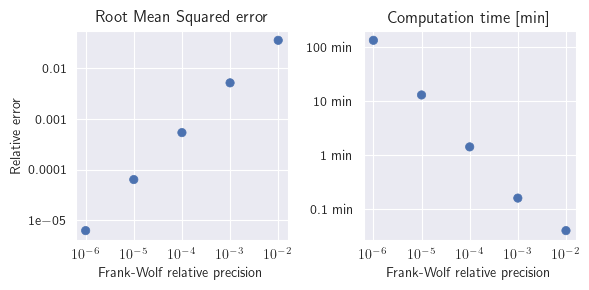

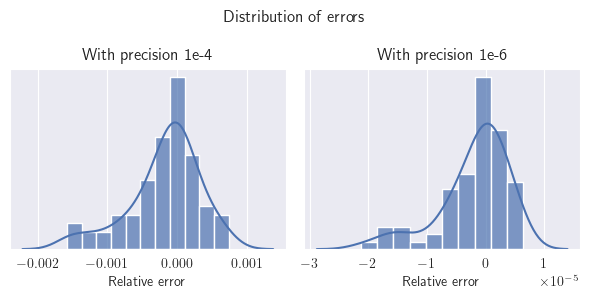

In [14]:
# Compare the results
net.TNTP_flows.columns = net.TNTP_flows.columns.str.rstrip()
df = net.TNTP_flows.set_index(["From", "To"])
root_mean_square = np.zeros(5)
root_mean_square_abs = np.zeros(5)
mean_error = np.zeros(5)
mean_error_abs = np.zeros(5)
for p in range(2, 7, 1):
    frankwolf_flows = net.load_flow(f"fw_p{p}", folder = os.path.join("files", "precision"), dim=1)
    computed_flows = pd.DataFrame(net.get_edges([frankwolf_flows]), columns=["From", "To", f"p{p}"])
    computed_flows[["From", "To"]] += 1
    computed_flows = computed_flows.set_index(["From", "To"])
    df = df.join(computed_flows, how="outer")
    df[f"Diff_p{p}"] = df["Volume"] - df[f"p{p}"]
    df[f"Diff_rel_p{p}"] = df[f"Diff_p{p}"]/df["Volume"]
    root_mean_square_abs[p-2] = ((df[f"Diff_p{p}"]**2).mean())**0.5
    root_mean_square[p-2] = ((df[f"Diff_rel_p{p}"]**2).mean())**0.5
    mean_error[p-2] = df[f"Diff_rel_p{p}"].mean()
    mean_error_abs[p-2] = df[f"Diff_p{p}"].mean()


#Table

df2 = pd.DataFrame({
    "Precision" : np.arange(2,7,1),
    "Root mean square (absolute error)" : root_mean_square_abs,
    "Root mean square (relative error)" : root_mean_square,
    "Mean relative error": mean_error,
    "Computation time [min]" : [0.04, 0.16, 1.42, 12.99, 133.60],
    })
df2["Precision"] = df2.Precision.apply("10^-{}".format)
df2 = df2.set_index("Precision")
display(df2)

# Plots
sns.set_style("darkgrid")
fig, axs = plt.subplots(1, 2, layout="tight", figsize=(6, 3))
(
    so.Plot(x=10.0**-np.arange(2,7,1), y=root_mean_square, text=root_mean_square)
    .add(so.Dot())
    .scale(x="log", y=so.Continuous(trans="log").label(like="{x:.3g}", base=None))
    .label(x="Frank-Wolf relative precision", title = "Root Mean Squared error", y="Relative error")
    .on(axs[0])
    .plot()
)
(
    so.Plot(x=10.0**-np.arange(2,7,1) , y=[0.04, 0.16, 1.42, 12.99, 133.60])
    .add(so.Dot())
    .scale(x="log", y=so.Continuous(trans="log").label(like="{x:.3g} min",base=None))
    .label(title="Computation time [min]", x="Frank-Wolf relative precision")
    .on(axs[1])
    .plot()
)

fig.savefig("figs/fw_errors.pgf", bbox_inches = 'tight')

plt.show()
fig, axs = plt.subplots(1, 2, layout="tight", figsize=(6, 3))
(
    so.Plot(x = df["Diff_rel_p4"])
    .add(so.Bars(), so.Hist(stat="density"))
    .add(so.Line(), so.KDE())
    .label(x="Relative error", title="With precision 1e-4")
    .on(axs[0])
    .plot()
)
(
    so.Plot(x = df["Diff_rel_p6"])
    .add(so.Bars(), so.Hist(stat="density"))
    .add(so.Line(), so.KDE())
    .label(x="Relative error", title="With precision 1e-6")
    .on(axs[1])
    .plot()
)
axs[0].set_yticks([])
axs[1].set_yticks([])
plt.suptitle("Distribution of errors")
plt.savefig("figs/fw_error_dist.pgf", bbox_inches = 'tight')
plt.show()


#### SO

Now, we compute for 1e-4 and 1e-6 for System Optimum : we change the time function to work with marginal time

In [15]:
# Frank-Wolf for System Optimum

# First with precision 1e-4
SO_fw_by_origin, SO_flows = frankwolf(net, net.trips, cost_function=BTR_marginal_cost_function, verbose=1, tolerance= 1e-4, n_max=2e5)
net.save_flow(SO_fw_by_origin, "SO_FrankWolf_by_origin_p4")
net.save_flow(SO_flows, "SO_flows_p4")
net.export_flow(SO_fw_by_origin, "SO_FrankWolf_by_origin_p4")
net.export_flow(SO_flows, "SO_flows_p4")


# Then with precision 1e-6
SO_fw_by_origin, SO_flows = frankwolf(net, net.trips, cost_function=BTR_marginal_cost_function, verbose=1, tolerance= 1e-6, n_max=2e5)
net.save_flow(SO_fw_by_origin, "SO_FrankWolf_by_origin")
net.save_flow(SO_flows, "SO_flows")
net.export_flow(SO_fw_by_origin, "SO_FrankWolf_by_origin")
net.export_flow(SO_flows, "SO_flows")


1974it [01:35, 20.73it/s, Relative error=9.64e-05]
180773it [2:48:19, 17.90it/s, Relative error=9.52e-07]


#### Visualisation

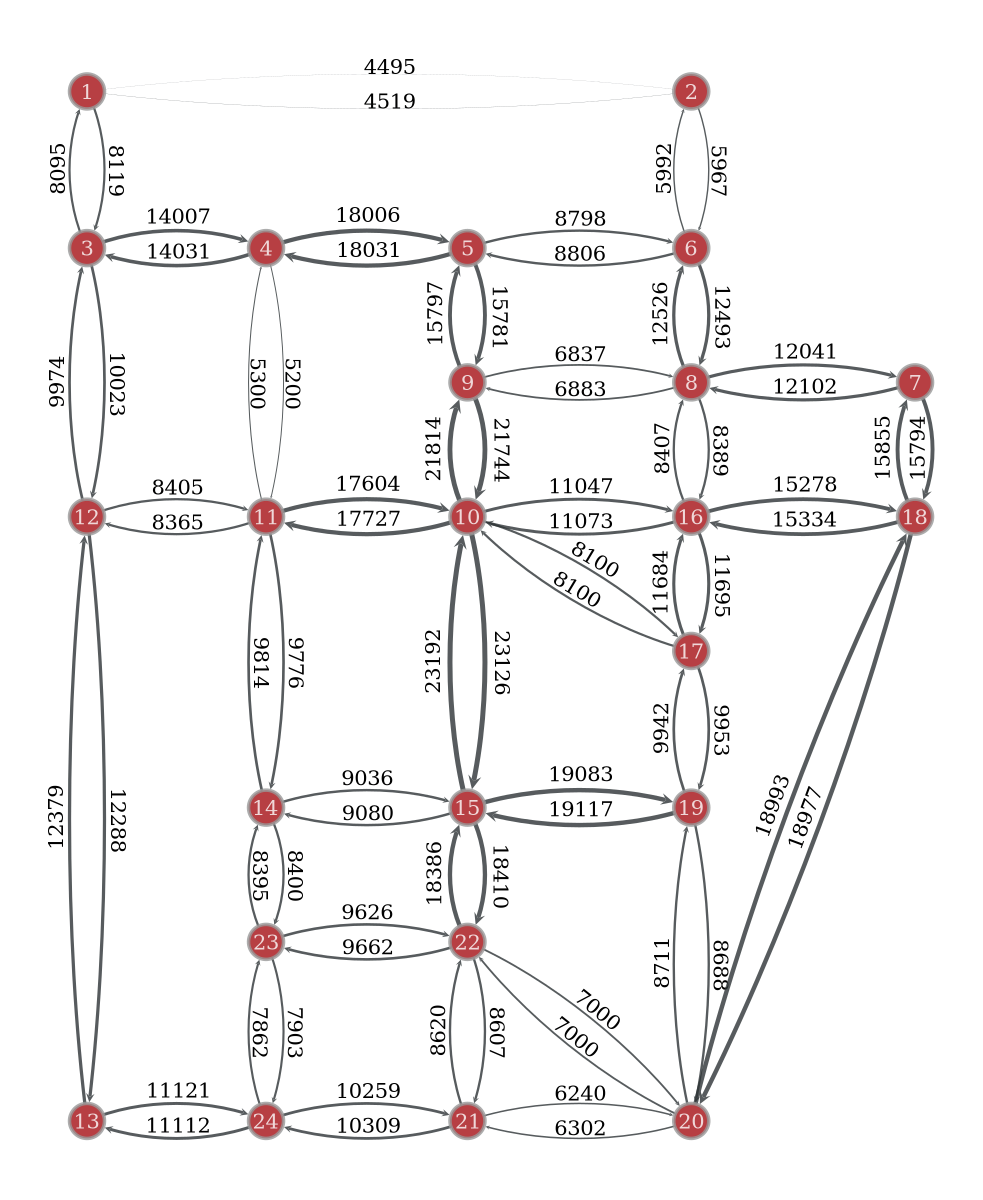

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2d0e1c58b0, at 0x7f2d0cbdf020>

In [16]:
# UE
UE_flows = net.load_flow("UE_flows")
net.draw(flows = UE_flows)

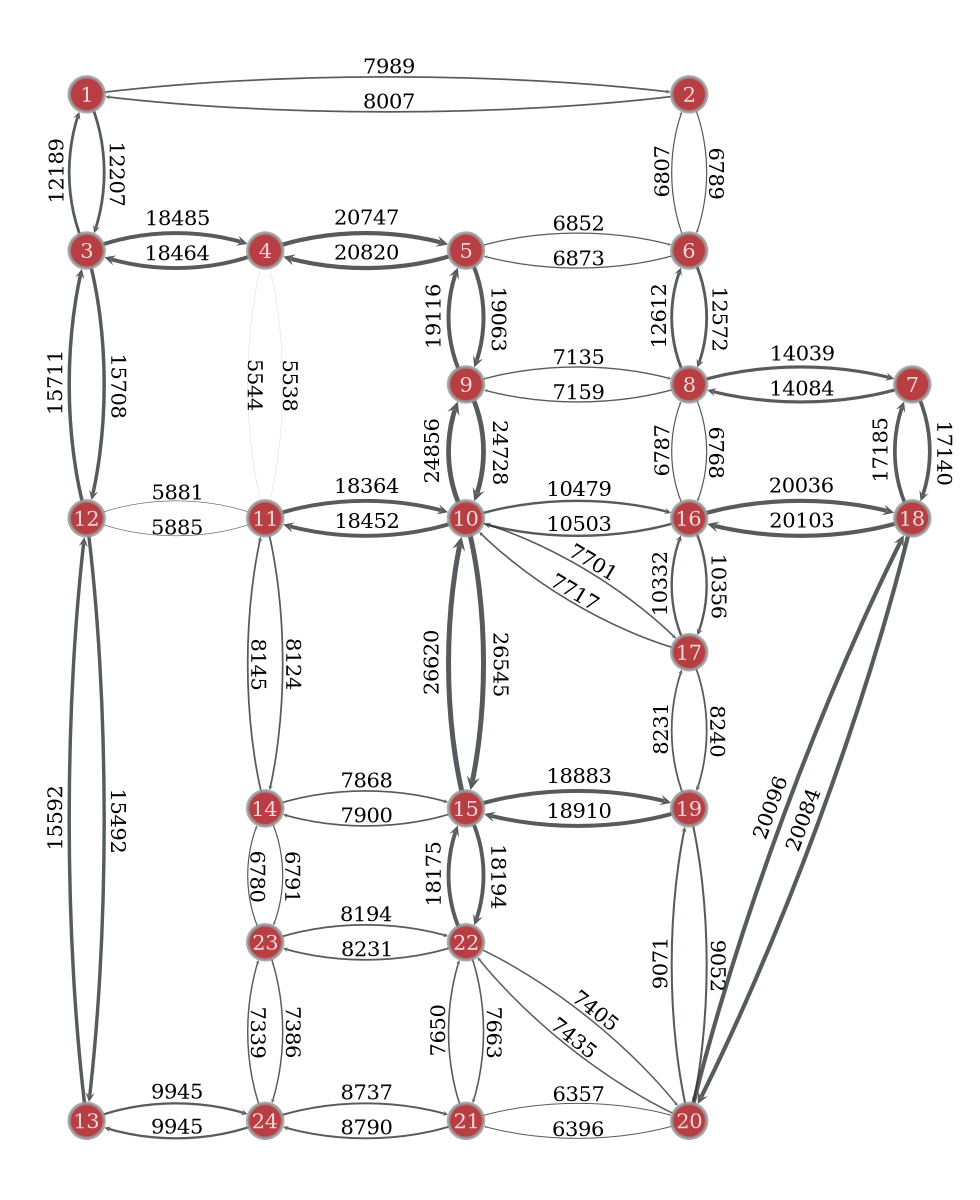

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2d0e1c58b0, at 0x7f2d0cca9fd0>

In [17]:
# SO
SO_flows = net.load_flow("SO_flows")
net.draw(flows = SO_flows)

### EMARB : Equilibrated origin-based bushes

Now is time to apply Entropy Maximisation through Alternative Representation of bushes, from Xie and Nie. Firstly, we need to tune the 'epsilon' parameter, which also determines when to stop the algorithm

#### Tuning the Epsilon parameter

In [18]:
p=1
epsilon = 10**(-p)

# UE
frankwolf_by_origin = net.load_flow("UE_FrankWolf_by_origin")
flows_by_o = EMARB(net, frankwolf_by_origin, epsilon=epsilon)
net.save_flow(flows_by_o, f"UE_flows_by_o_EMARB_p{p}")
net.export_flow(flows_by_o, f"UE_flows_by_o_EMARB_p{p}")

# SO
frankwolf_by_origin = net.load_flow("SO_FrankWolf_by_origin")
flows_by_o = EMARB(net, frankwolf_by_origin, epsilon=epsilon)
net.save_flow(flows_by_o, f"SO_flows_by_o_EMARB_p{p}")
net.export_flow(flows_by_o, f"SO_flows_by_o_EMARB_p{p}")

0it [00:00, ?it/s]

1: X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X: 100%|██████████| 24/24 [00:34<00:00,  1.43s/it]
2:  . .X.X.X.X. . . .X.X.X.X. .X.X.X. . .X. .X.X.X: 100%|██████████| 24/24 [00:22<00:00,  1.07it/s]
3:  . .X. . . . .X.X.X.X.X. . .X.X.X. .X.X. . .X.X: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]
4:  .X.X.X. . . .X. .X.X.X.X.X. .X.X. . . .X.X. . : 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]
5:  . .X.X.X. .X.X. .X. .X. .X.X.X.X. . . .X. .X.X: 100%|██████████| 24/24 [00:31<00:00,  1.31s/it]
6:  . .X.X. .X. .X. .X. .X. . .X.X.X. . . .X. . . : 100%|██████████| 24/24 [00:11<00:00,  2.15it/s]
7:  . .X.X.X. . .X. .X. .X. . . .X.X. . . . . . .X: 100%|██████████| 24/24 [00:10<00:00,  2.37it/s]
8:  . .X.X. . . .X. .X. .X.X. .X.X.X. . . . . . . : 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]
9:  . .X.X. .X. .X. .X.X.X. . .X.X.X. .X. .X.X. . : 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]
10:  . .X.X.X.X.X.X. .X.X.X. . . .X.X. . . . . . . : 100%|██████████| 24/24 [00:28<00:00,  1.17s/it]

In [19]:
p=2
epsilon = 10**(-p)

# UE
frankwolf_by_origin = net.load_flow("UE_FrankWolf_by_origin")
flows_by_o = EMARB(net, frankwolf_by_origin, epsilon=epsilon)
net.save_flow(flows_by_o, f"UE_flows_by_o_EMARB_p{p}")
net.export_flow(flows_by_o, f"UE_flows_by_o_EMARB_p{p}")

# SO
frankwolf_by_origin = net.load_flow("SO_FrankWolf_by_origin")
flows_by_o = EMARB(net, frankwolf_by_origin, epsilon=epsilon)
net.save_flow(flows_by_o, f"SO_flows_by_o_EMARB_p{p}")
net.export_flow(flows_by_o, f"SO_flows_by_o_EMARB_p{p}")

1: X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X: 100%|██████████| 24/24 [00:34<00:00,  1.44s/it]
1it [00:34, 34.60s/it]

2:  . .X.X.X.X. . . .X.X.X.X. .X.X.X. . .X. .X.X.X: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]
3:  . .X. . . . .X.X.X.X.X. . .X.X.X. .X.X. . .X.X: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]
4:  .X.X.X. . . .X. .X.X.X.X.X. .X.X. . . .X.X. . : 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]
5:  . .X.X.X. .X.X. .X. .X. .X.X.X.X. . . .X. .X.X: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it]
6:  . .X.X. .X. .X. .X. .X. . .X.X.X. . . .X. . . : 100%|██████████| 24/24 [00:12<00:00,  1.93it/s]
7:  . .X.X.X. . .X. .X. .X. . . .X.X. . . . . . .X: 100%|██████████| 24/24 [00:13<00:00,  1.75it/s]
8:  . .X.X. . . .X. .X. .X.X. .X.X.X. . . . . . . : 100%|██████████| 24/24 [00:10<00:00,  2.37it/s]
9:  . .X.X. .X. .X. .X.X.X. . .X.X.X. .X. .X.X. . : 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]
10:  . .X.X.X.X.X.X. .X.X.X. . . .X.X. . . . . . . : 100%|██████████| 24/24 [00:29<00:00,  1.25s/it]
11:  . .X.X. . . .X. .X. .X. . . .X.X. . . . . . . : 100%|██████████| 24/24 [00:14<00:00,  1.67it/s

In [20]:
p=3
epsilon = 10**(-p)

# UE
frankwolf_by_origin = net.load_flow("UE_FrankWolf_by_origin")
flows_by_o = EMARB(net, frankwolf_by_origin, epsilon=epsilon)
net.save_flow(flows_by_o, f"UE_flows_by_o_EMARB_p{p}")
net.export_flow(flows_by_o, f"UE_flows_by_o_EMARB_p{p}")

# SO
frankwolf_by_origin = net.load_flow("SO_FrankWolf_by_origin")
flows_by_o = EMARB(net, frankwolf_by_origin, epsilon=epsilon)
net.save_flow(flows_by_o, f"SO_flows_by_o_EMARB_p{p}")
net.export_flow(flows_by_o, f"SO_flows_by_o_EMARB_p{p}")

0it [00:00, ?it/s]

1: X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X.X: 100%|██████████| 24/24 [00:35<00:00,  1.46s/it]
2:  . .X.X.X.X. . . .X.X.X.X. .X.X.X. . .X. .X.X.X: 100%|██████████| 24/24 [00:21<00:00,  1.11it/s]
3:  . .X. . . . .X.X.X.X.X. . .X.X.X. .X.X. . .X.X: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]
4:  .X.X.X. . . .X. .X.X.X.X.X. .X.X. . . .X.X. . : 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]
5:  . .X.X.X. .X.X. .X. .X. .X.X.X.X. . . .X. .X.X: 100%|██████████| 24/24 [00:32<00:00,  1.34s/it]
6:  . .X.X. .X. .X. .X. .X. . .X.X.X. . . .X. . . : 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]
7:  . .X.X.X. . .X. .X. .X. . . .X.X. . . . . . .X: 100%|██████████| 24/24 [00:12<00:00,  1.93it/s]
8:  . .X.X. . . .X. .X. .X.X. .X.X.X. . . . . . . : 100%|██████████| 24/24 [00:10<00:00,  2.32it/s]
9:  . .X.X. .X. .X. .X.X.X. . .X.X.X. .X. .X.X. . : 100%|██████████| 24/24 [00:13<00:00,  1.73it/s]
10:  . .X.X.X.X.X.X. .X.X.X. . . .X.X. . . . . . . : 100%|██████████| 24/24 [00:29<00:00,  1.24s/it]

Now, we can see what changes in the results :

For epsilon = 0.1 (UE) : 	N = 0 : 3, 	N <0.1 : 1178, 	N <1 : 1178, 	Ntot : 1824
For epsilon = 0.1 (SO) : 	N = 0 : 4, 	N <0.1 : 1152, 	N <1 : 1154, 	Ntot : 1824
For epsilon = 0.01 (UE) : 	N = 0 : 3, 	N <0.1 : 1178, 	N <1 : 1178, 	Ntot : 1824
For epsilon = 0.01 (SO) : 	N = 0 : 3, 	N <0.1 : 1152, 	N <1 : 1154, 	Ntot : 1824
For epsilon = 0.001 (UE) : 	N = 0 : 5, 	N <0.1 : 1178, 	N <1 : 1178, 	Ntot : 1824
For epsilon = 0.001 (SO) : 	N = 0 : 4, 	N <0.1 : 1152, 	N <1 : 1154, 	Ntot : 1824


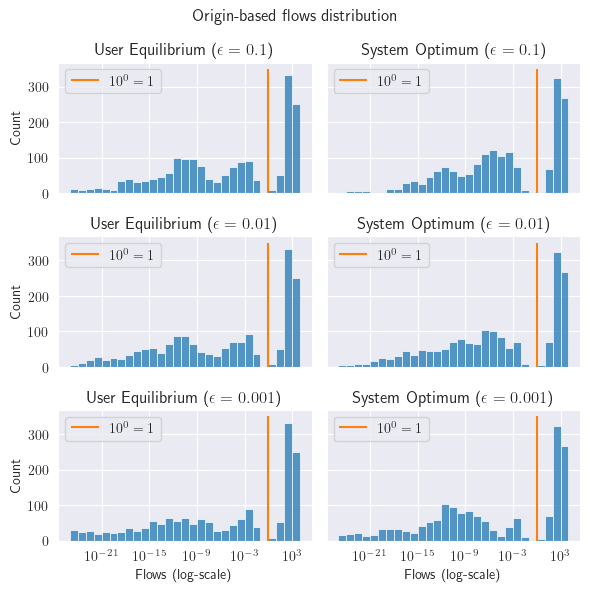

In [21]:
fig, axs = plt.subplots(3, 2, figsize = (6, 6), layout = "tight", sharex=True, sharey=True)
plt.suptitle("Origin-based flows distribution")
for i, axs_row in enumerate(axs):
    flows_by_o = net.load_flow(f"UE_flows_by_o_EMARB_p{i+1}")
    flows_by_o_array = flows_by_o.get_2d_array()
    print(f"For epsilon = {10.**-(i+1):.3g} (UE) : \tN = 0 : {((flows_by_o_array == 0)).sum()}, \tN <0.1 : {((flows_by_o_array < 0.1)).sum()}, \tN <1 : {((flows_by_o_array < 1)).sum()}, \tNtot : {flows_by_o_array.size}")
    sns.histplot(x=flows_by_o_array[flows_by_o_array>0], bins=np.arange(-25, 5, 1), log_scale=True, ax=axs_row[0])
    axs_row[0].set_title(f"User Equilibrium ($\\epsilon ={10.0**-(i+1):.3g}$)")
    axs_row[0].set_xlabel(f"Flows (log-scale)")
    axs_row[0].vlines(1, ymin=0, ymax=350, color="C1", label="$10^0 = 1$")
    axs_row[0].legend()

    flows_by_o = net.load_flow(f"SO_flows_by_o_EMARB_p{i+1}")
    flows_by_o_array = flows_by_o.get_2d_array()
    print(f"For epsilon = {10.**-(i+1):.3g} (SO) : \tN = 0 : {((flows_by_o_array == 0)).sum()}, \tN <0.1 : {((flows_by_o_array < 0.1)).sum()}, \tN <1 : {((flows_by_o_array < 1)).sum()}, \tNtot : {flows_by_o_array.size}")
    sns.histplot(x=flows_by_o_array[flows_by_o_array>0], bins=np.arange(-25, 5, 1), log_scale=True, ax=axs_row[1])
    axs_row[1].set_title(f"System Optimum ($\\epsilon ={10.0**-(i+1):.3g}$)")
    axs_row[1].set_xlabel(f"Flows (log-scale)")
    axs_row[1].vlines(1, ymin=0, ymax=350, color="C1", label="$10^0 = 1$")
    axs_row[1].legend()
plt.savefig("figs/EMARB_epsilon.pgf", bbox_inches="tight")
plt.show()

Given the importance of this calculation, we will continue with using the highest precision ($\epsilon = 0.001$). However, we see that we have a big range of nearly negative values. In order to keep the values, and because keeping flows in the order of 10^-7 would not make sense, we will reduce any value smaller than this epsilon to 0 :

In [22]:
threshold = 1e-3

#UE
flows_by_o = net.load_flow("UE_flows_by_o_EMARB_p3")
net.save_flow(flows_by_o, "UE_flows_by_o_EMARB")# rename, without the filter
net.export_flow(flows_by_o, "UE_flows_by_o_EMARB")# rename, without the filter
flows_by_o_array = flows_by_o.get_2d_array()
flows_by_o_filtered = flows_by_o.copy()
flows_by_o_array = np.where(flows_by_o_array >= threshold, flows_by_o_array, 0)
flows_by_o_filtered.set_2d_array(flows_by_o_array)

net.save_flow(flows_by_o_filtered, "UE_flows_by_o_filtered")
net.export_flow(flows_by_o_filtered, "UE_flows_by_o_filtered")


#SO
flows_by_o = net.load_flow("SO_flows_by_o_EMARB_p3")
net.save_flow(flows_by_o, "SO_flows_by_o_EMARB")# rename, without the filter
net.export_flow(flows_by_o, "SO_flows_by_o_EMARB")# rename, without the filter
flows_by_o_array = flows_by_o.get_2d_array()
flows_by_o_filtered = flows_by_o.copy()
flows_by_o_array = np.where(flows_by_o_array >= threshold, flows_by_o_array, 0)
flows_by_o_filtered.set_2d_array(flows_by_o_array)

net.save_flow(flows_by_o_filtered, "SO_flows_by_o_filtered")
net.export_flow(flows_by_o_filtered, "SO_flows_by_o_filtered")

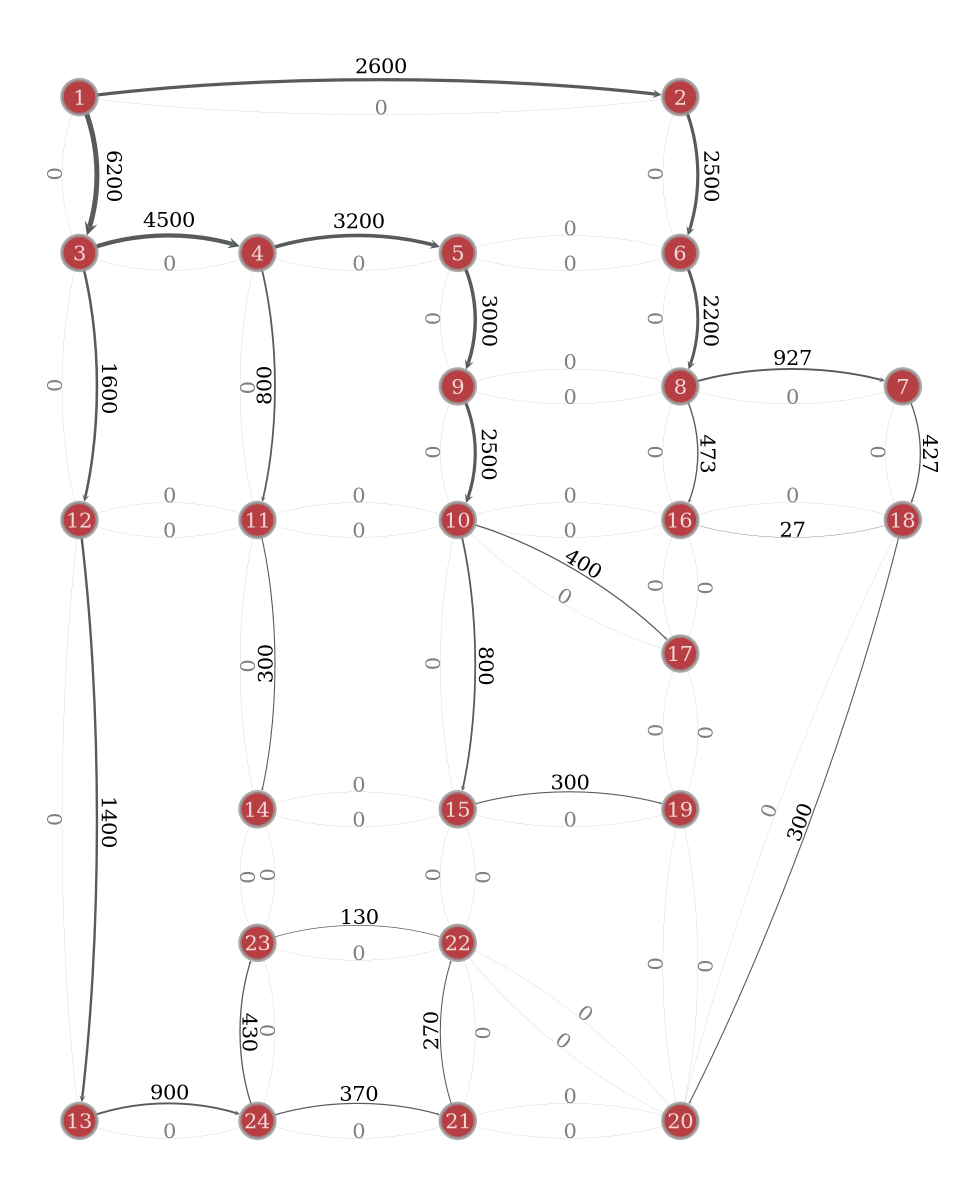

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2d0e1c58b0, at 0x7f2d0cbb0d40>

In [23]:
#Visualisations
flows_by_o = net.load_flow("UE_flows_by_o_filtered")

net.draw(flows_by_o = flows_by_o, o=1)

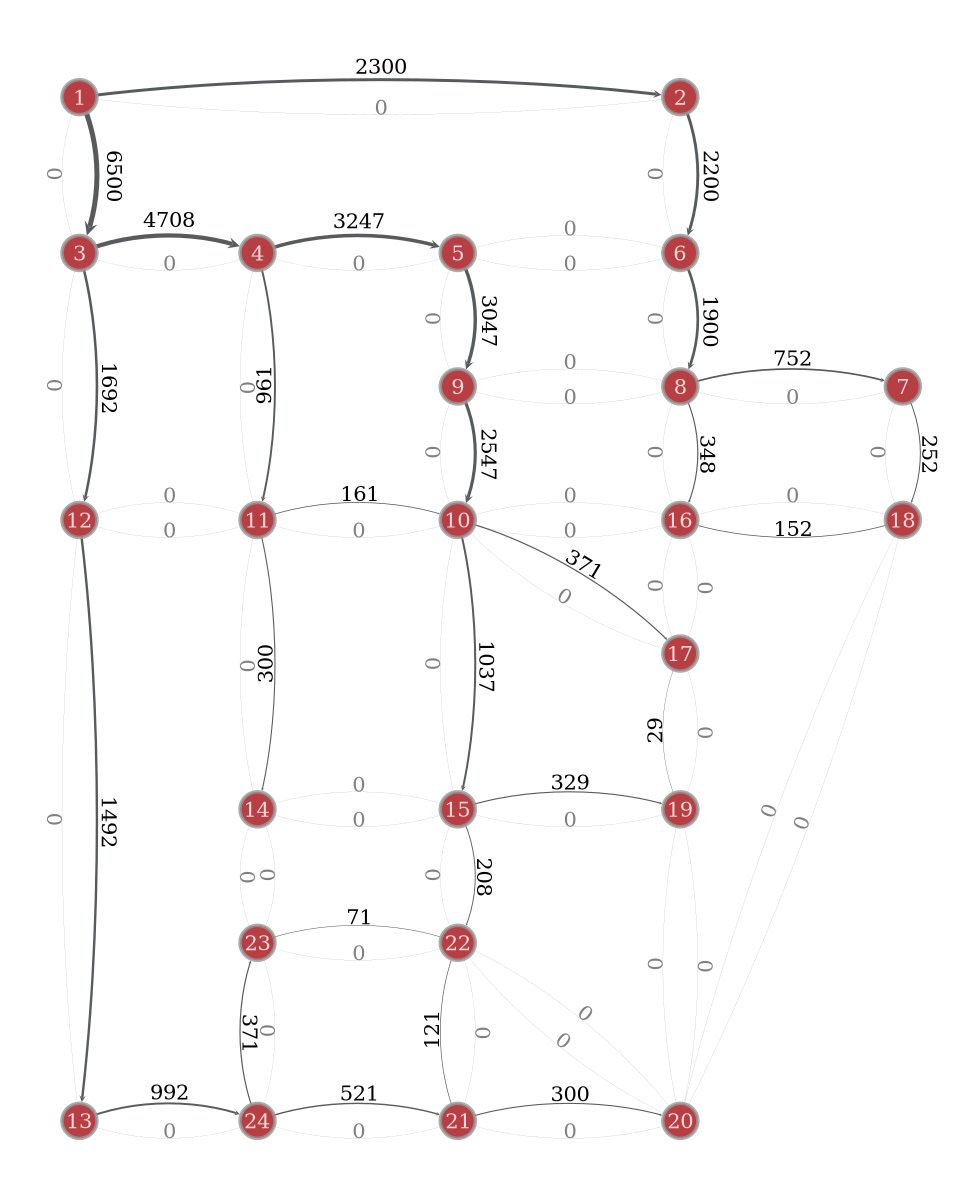

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2d0e1c58b0, at 0x7f2d0d0875f0>

In [24]:
#Visualisations
flows_by_o = net.load_flow("SO_flows_by_o_filtered")

net.draw(flows_by_o = flows_by_o, o=1)

### Paths and OD flows

Now, we can compute the paths and the link flows associated with each OD. To do so, we will use the function `get_OD_flows` from `EntopyMaximisation.py`. This function is based on the appendix of Xie and Nie's paper. We have implemented a flow_limit argument, that discards paths whose flows are smaller than the argument value. This argument has been made necessary by the method we get the paths and the flows. Indeed, the total number of paths from two node is big and considering paths that goes through many nodes, with flows very small, would not make sense.

Here we will choose a value of 0.1 : compared with the order of the demands ($10^2$), we consider that paths with flows at least a thousand time smaller can be dismissed. Additionnally, we might consider our errors at the start (after applying frankwolf algorithm) are just below this value (the mean square error is 0.07).

In [25]:
# UE  
flows_by_o = net.load_flow("UE_flows_by_o_filtered")

OD_flows, paths = get_OD_flows(net, net.trips, flows_by_origin=flows_by_o, flow_limit = 0.1, return_paths=True)
net.save_flow(OD_flows, "UE_OD_flows")
net.export_flow(OD_flows, "UE_OD_flows", OD_demand=net.trips)
_ = net.export_paths(paths, net.trips, name="UE_paths")

# SO
flows_by_o = net.load_flow("SO_flows_by_o_filtered")

OD_flows, paths = get_OD_flows(net, net.trips, flows_by_origin=flows_by_o, flow_limit = 0.1, return_paths=True)
net.save_flow(OD_flows, "SO_OD_flows")
net.export_flow(OD_flows, "SO_OD_flows", OD_demand=net.trips)
_ = net.export_paths(paths, net.trips, name="SO_paths")

 38%|███▊      | 9/24 [00:25<00:40,  2.68s/it]

100%|██████████| 24/24 [01:09<00:00,  2.91s/it]


To compare, we can see what would have happened without limiting the flows :

In [26]:
# Get the EMARB results
flows_by_o_UE = net.load_flow("UE_flows_by_o_filtered")
flows_by_o_SO = net.load_flow("SO_flows_by_o_filtered")

# Compute the paths and their flows
OD_flows_comp_UE, paths_comp_UE = get_OD_flows(net, net.trips, flows_by_origin=flows_by_o_UE, flow_limit = 1e-3000, return_paths=True)
OD_flows_comp_SO, paths_comp_SO = get_OD_flows(net, net.trips, flows_by_origin=flows_by_o_SO, flow_limit = 1e-3000, return_paths=True)

# Save for potential future use :
net.save_flow(OD_flows_comp_UE, "UE_OD_flows_no_limit")
net.export_flow(OD_flows_comp_UE, "UE_OD_flows_no_limit", OD_demand=net.trips)
net.export_paths(paths_comp_UE, net.trips, name="UE_paths_no_limit")

net.save_flow(OD_flows_comp_SO, "SO_OD_flows_no_limit")
net.export_flow(OD_flows_comp_SO, "SO_OD_flows_no_limit", OD_demand=net.trips)
net.export_paths(paths_comp_SO, net.trips, name="SO_paths_no_limit")


 17%|█▋        | 4/24 [00:09<00:48,  2.41s/it]

100%|██████████| 24/24 [01:09<00:00,  2.91s/it]


'  2 ->   1 (100.0):\n\t     100 : [2, 1]\n\n  3 ->   1 (100.0):\n\t     100 : [3, 1]\n\n  4 ->   1 (500.0):\n\t     500 : [4, 3, 1]\n\n  5 ->   1 (200.0):\n\t     200 : [5, 4, 3, 1]\n\n  6 ->   1 (300.0):\n\t     300 : [6, 2, 1]\n\n  7 ->   1 (500.0):\n\t     500 : [7, 8, 6, 2, 1]\n\n  8 ->   1 (800.0):\n\t     800 : [8, 6, 2, 1]\n\n  9 ->   1 (500.0):\n\t     500 : [9, 5, 4, 3, 1]\n\n 10 ->   1 (1300.0):\n\t1.23e+03 : [10, 9, 5, 4, 3, 1]\n\t    69.7 : [10, 11, 4, 3, 1]\n\n 11 ->   1 (500.0):\n\t     500 : [11, 4, 3, 1]\n\n 12 ->   1 (200.0):\n\t     200 : [12, 3, 1]\n\n 13 ->   1 (500.0):\n\t     500 : [13, 12, 3, 1]\n\n 14 ->   1 (300.0):\n\t     300 : [14, 11, 4, 3, 1]\n\n 15 ->   1 (500.0):\n\t     473 : [15, 10, 9, 5, 4, 3, 1]\n\t    26.8 : [15, 10, 11, 4, 3, 1]\n\t2.71e-05 : [15, 14, 11, 4, 3, 1]\n\n 16 ->   1 (500.0):\n\t     153 : [16, 18, 7, 8, 6, 2, 1]\n\t     347 : [16, 8, 6, 2, 1]\n\n 17 ->   1 (400.0):\n\t    26.6 : [17, 19, 15, 10, 9, 5, 4, 3, 1]\n\t     352 : [17, 10, 9

Text(0.5, 0.98, 'Distribution of the OD link flows, with limiting the flows to $> 0.1$')

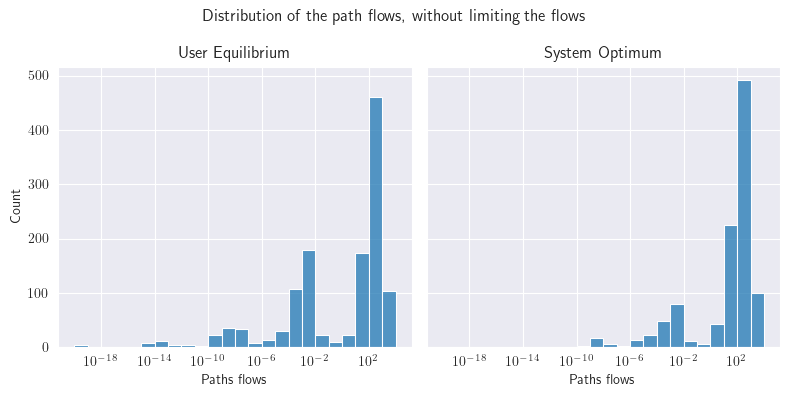

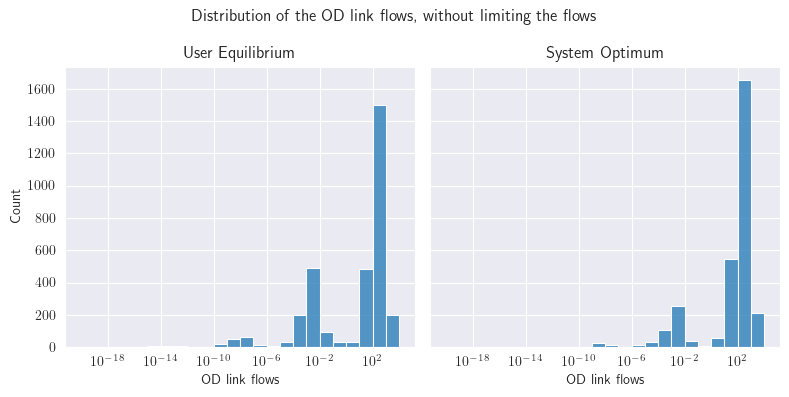

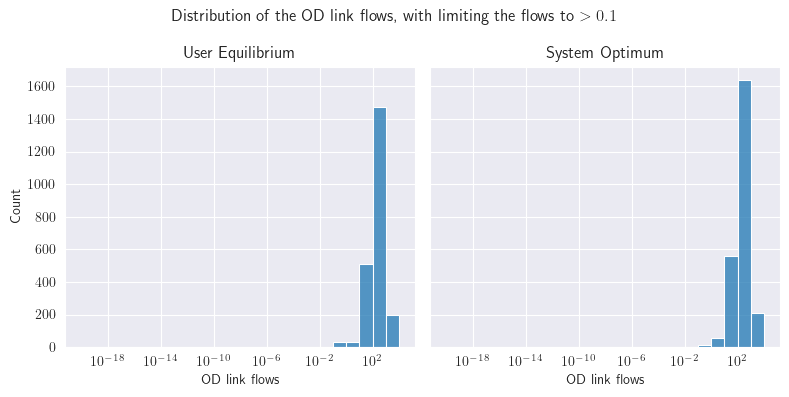

In [27]:
# Plot the histograms

# Path flows
fig1, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, layout="tight", figsize = (8, 4))
plt.suptitle("Distribution of the path flows, without limiting the flows")
# path flows UE
path_flows_comp = np.array(sum([[f for _,f in p] for p in paths_comp_UE.values()], []))
sns.histplot(x=path_flows_comp[(path_flows_comp>0)], bins=np.arange(-20, 5, 1), log_scale=True, ax=ax1)
ax1.set_title("User Equilibrium")
ax1.set_xlabel("Paths flows")
# path flows SO
path_flows_comp = np.array(sum([[f for _,f in p] for p in paths_comp_SO.values()], []))
sns.histplot(x=path_flows_comp[(path_flows_comp>0)], bins=np.arange(-20, 5, 1), log_scale=True, ax=ax2)
ax2.set_title("System Optimum")
ax2.set_xlabel("Paths flows")

# O-D link flows
fig2, (ax3, ax4) = plt.subplots(1, 2, sharex=True, sharey=True, layout="tight", figsize = (8, 4))
sns.histplot(x=OD_flows_comp_UE[(OD_flows_comp_UE>0)], bins=np.arange(-20, 5, 1), log_scale=True, ax=ax3)
ax3.set_title("User Equilibrium")
ax3.set_xlabel("OD link flows")
sns.histplot(x=OD_flows_comp_SO[(OD_flows_comp_SO>0)], bins=np.arange(-20, 5, 1), log_scale=True, ax=ax4)
ax4.set_title("System Optimum")
ax4.set_xlabel("OD link flows")
plt.suptitle("Distribution of the OD link flows, without limiting the flows")

# For comparison, OD link flows with limiting the flows
UE_OD_flows = net.load_flow("UE_OD_flows")
SO_OD_flows = net.load_flow("SO_OD_flows")
fig3, (ax5, ax6) = plt.subplots(1, 2, sharex=True, sharey=True, layout="tight", figsize = (8, 4))
sns.histplot(x=UE_OD_flows[(UE_OD_flows>0)], bins=np.arange(-20, 5, 1), log_scale=True, ax=ax5)
ax5.set_title("User Equilibrium")
ax5.set_xlabel("OD link flows")
sns.histplot(x=SO_OD_flows[(SO_OD_flows>0)], bins=np.arange(-20, 5, 1), log_scale=True, ax=ax6)
ax6.set_title("System Optimum")
ax6.set_xlabel("OD link flows")
plt.suptitle("Distribution of the OD link flows, with limiting the flows to $> 0.1$")


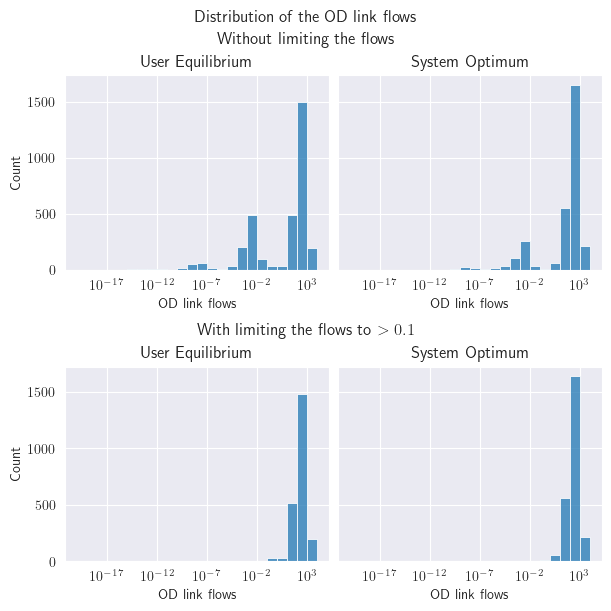

In [28]:
# Plot the histograms (1 fig)

OD_flows_comp_UE = net.load_flow("UE_OD_flows_no_limit")
OD_flows_comp_SO = net.load_flow("SO_OD_flows_no_limit")
# O-D link flows
fig = plt.figure(figsize= (6,6), layout="constrained")
plt.suptitle("Distribution of the OD link flows")
sfig1, sfig2 = fig.subfigures(2)
(ax3, ax4) = sfig1.subplots(1, 2, sharex=True, sharey=True)
fig2.subfigures(2, 1)
sns.histplot(x=OD_flows_comp_UE[(OD_flows_comp_UE>0)], bins=np.arange(-20, 5, 1), log_scale=True, ax=ax3)
ax3.set_title("User Equilibrium")
ax3.set_xlabel("OD link flows")
sns.histplot(x=OD_flows_comp_SO[(OD_flows_comp_SO>0)], bins=np.arange(-20, 5, 1), log_scale=True, ax=ax4)
ax4.set_title("System Optimum")
ax4.set_xlabel("OD link flows")
sfig1.suptitle("Without limiting the flows")

# For comparison, OD link flows with limiting the flows
UE_OD_flows = net.load_flow("UE_OD_flows")
SO_OD_flows = net.load_flow("SO_OD_flows")
(ax5, ax6) = sfig2.subplots(1, 2, sharex=True, sharey=True)
sns.histplot(x=UE_OD_flows[(UE_OD_flows>0)], bins=np.arange(-20, 5, 1), log_scale=True, ax=ax5)
ax5.set_title("User Equilibrium")
ax5.set_xlabel("OD link flows")
sns.histplot(x=SO_OD_flows[(SO_OD_flows>0)], bins=np.arange(-20, 5, 1), log_scale=True, ax=ax6)
ax6.set_title("System Optimum")
ax6.set_xlabel("OD link flows")
sfig2.suptitle("With limiting the flows to $> 0.1$")

fig.savefig("figs/OD_link_flows.pgf", bbox_inches="tight")

#### Visualisation

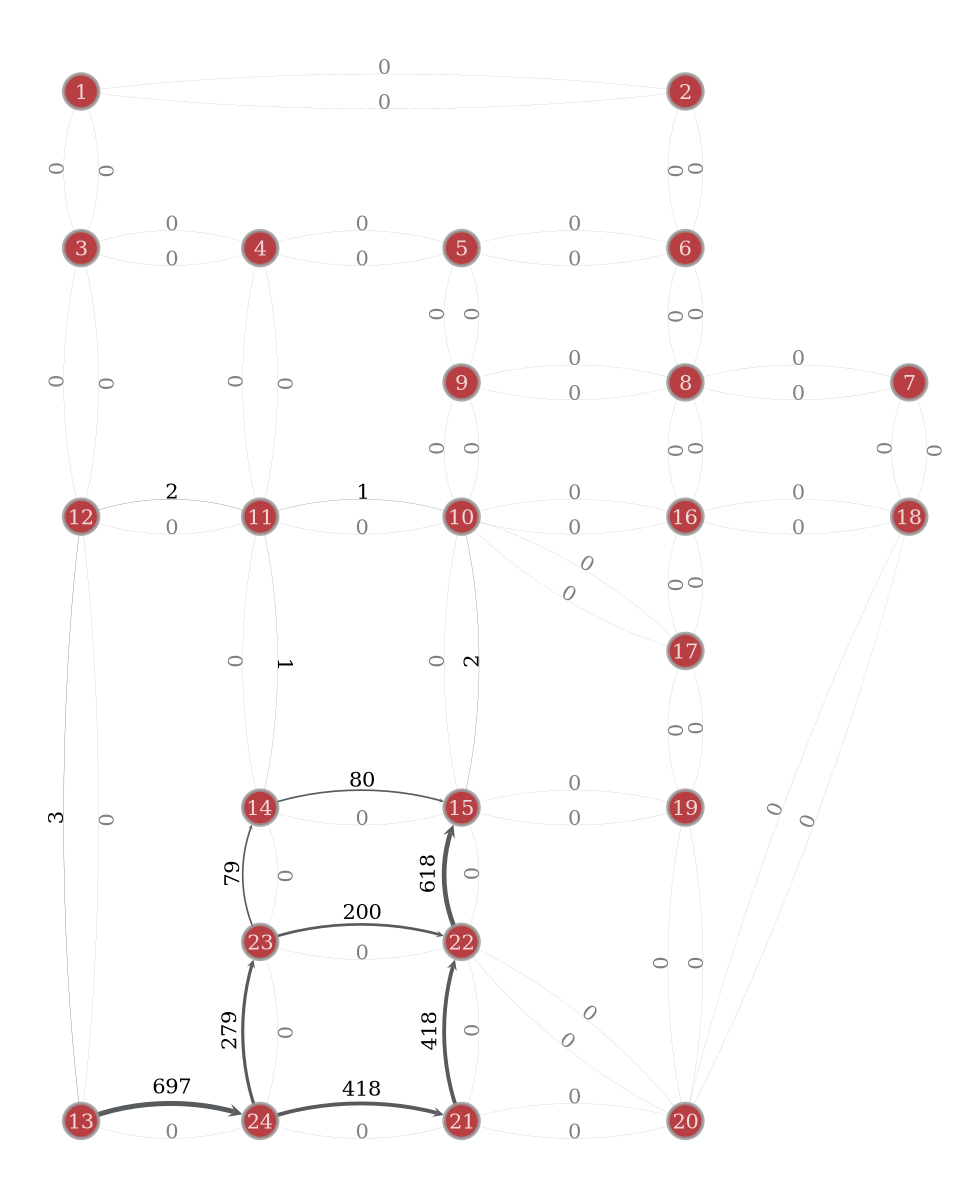

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2d0e1c58b0, at 0x7f2d0cccf560>

In [29]:
# UE
OD_flows = net.load_flow("UE_OD_flows")
net.draw(flows_by_OD = OD_flows, o=13, d=15)

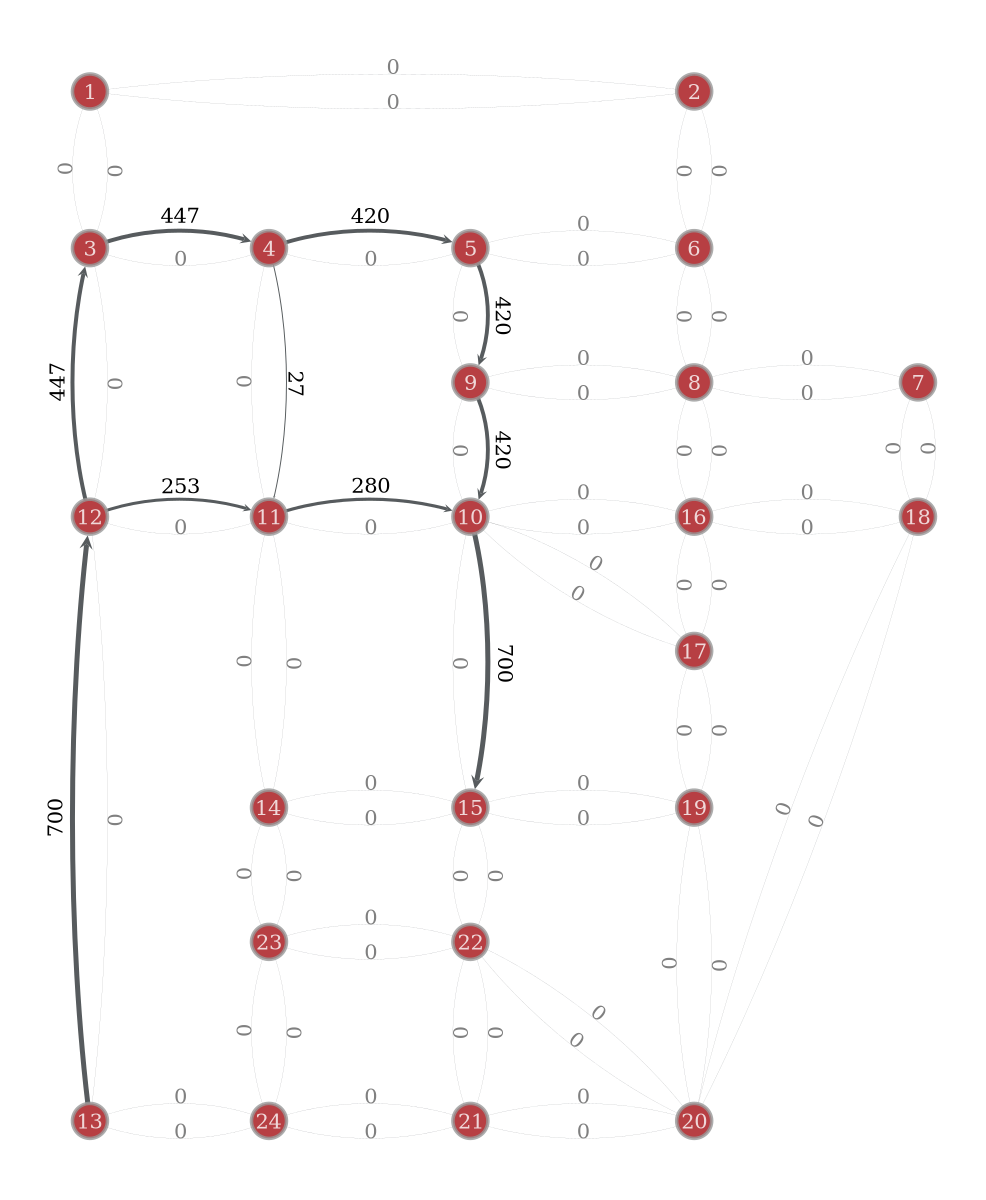

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2d0e1c58b0, at 0x7f2d0d10eea0>

In [30]:
# SO
OD_flows = net.load_flow("SO_OD_flows")
net.draw(flows_by_OD = OD_flows, o=13, d=15)